<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/language%20modelling/Language_Modelling_Sequence_to_Sequence_model_for_Poetry_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import range, input

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from keras.utils import plot_model, np_utils

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 256
EPOCHS = 200
LATENT_DIM = 100

In [5]:
try:
  from google.colab import files
  files.upload()
  input_texts = []
  target_texts = []
  text_files = glob.glob('*.txt')
  for line in open(text_files[0]):
    line = line.rstrip()
    if not line:
      continue 
    input_line = '<sos> ' + line 
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)
  all_lines = input_texts + target_texts
except Exception as ex:
  print(ex)

Saving poemsofrobertfro029898mbp_djvu.txt to poemsofrobertfro029898mbp_djvu.txt


In [0]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='')

In [0]:
tokenizer.fit_on_texts(all_lines)

In [0]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [0]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)

In [0]:
word2idx = tokenizer.word_index

In [11]:
print('Found {} unique words'.format(len(word2idx)))

Found 12331 unique words


In [0]:
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)

In [13]:
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print(f'Shape of data tensor {input_sequences.shape}')

Shape of data tensor (9684, 14)


In [14]:
import keras

# load in pretrained word vectors
import urllib
urllib.request.urlretrieve("https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz",filename="glove.6B.50d.txt.gz")

import gzip
import shutil
with gzip.open('glove.6B.50d.txt.gz', 'rb') as f_in:
    with open('glove.6B.50d.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

!ls -GFlash --color

# !rm -r poemsofrobertfro029898mbp_djvu\ \(1\).txt

word2vec = {}
with open('glove.6B.50d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f"Found {len(word2vec)} word vectors")

print('Filling pretrained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector      

one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequences in enumerate(target_sequences):
  for t, word in enumerate(target_sequences):
    if word > 0:
      one_hot_targets[i, t, word] = 1

embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM,
                            weights=[embedding_matrix]
                            )

input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h,initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=["accuracy"])

print('Training model..')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences, z, z],
          one_hot_targets,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=VALIDATION_SPLIT)

total 230M
4.0K drwxr-xr-x 1 root 4.0K Jan 19 13:17 ./
4.0K drwxr-xr-x 1 root 4.0K Jan 19 13:15 ../
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 .config/
164M -rw-r--r-- 1 root 164M Jan 19 13:17 glove.6B.50d.txt
 66M -rw-r--r-- 1 root  66M Jan 19 13:17 glove.6B.50d.txt.gz
356K -rw-r--r-- 1 root 355K Jan 19 13:17 poemsofrobertfro029898mbp_djvu.txt
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 sample_data/
Found 400000 word vectors
Filling pretrained embeddings...











Training model..
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6778 samples, validate on 2906 samples
Epoch 1/200
6778/6778 [==============================] - 5s 750us/step - loss: 3.2445 - acc: 0.0718 - val_loss: 2.5327 - val_acc: 0.0736
Epoch 2/200
6778/6778 [==============================] - 3s 412us/step - loss: 2.8776 - acc: 0.0786 - val_loss: 2.4287 - val_acc: 0.0735
Epoch 3/200
6778/6778 [==============================] - 3s 416us/step - loss: 2.7602 - acc: 0.0

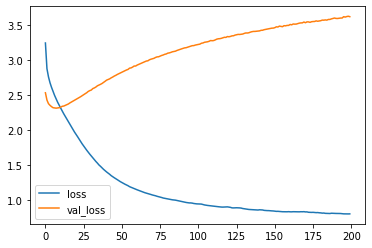

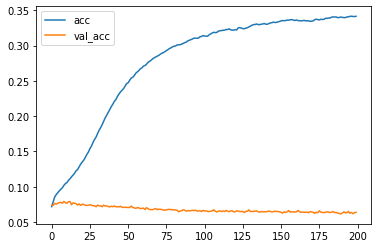

In [15]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [0]:
idx2word = {v:k for k,v in word2idx.items()}

In [0]:
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [0]:
def sample_line():
  np_input = np.array([[word2idx['<sos>']]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  eos = word2idx['<eos>']
  output_sequence = []
  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])
    probs = o[0,0]
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break
    output_sequence.append(idx2word.get(idx, '<WTF %s>'%idx))
    np_input[0,0] = idx
  return ' '.join(output_sequence)

In [27]:
while True:
  for _ in range(4):
    print(sample_line())
  ans = input("Generate another? [Y/n]")
  if ans and ans[0].lower().startswith('n'):
    break

and sleep on it the way a night
and where was either cloud there came of her,
there's you know the
'one is no life does get me how to know
Generate another? [Y/n]y
no one who would
that has him now to be or ready to
i thought the growing things went quite back,
for things would seemed too much at a
Generate another? [Y/n]y
with > look,
like nothing else by day, like ghosts by night;
you'll rest when i'm gone, perhaps
what was it? did you call me as if
Generate another? [Y/n]
if, as if what they were all,
don't ask to cut off the pasture i'm
of night air on the below
'the cellar bones make the bed or
Generate another? [Y/n]n
